In [1]:
! pip install pretrainedmodels

     |████████████████████████████████| 61kB 1.6MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60964 sha256=d34cb0b3315a9f6f8c7b41a12bc6978e3006b09786a047809fe1c27f7d36465a
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [2]:
from PIL import  Image
import torch
from torch.utils.data import Dataset,DataLoader,TensorDataset,ConcatDataset
from torchvision import transforms as trans
from torchvision import models,utils
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tqdm import tqdm
import pretrainedmodels
from torch import nn
from torch import optim
from torch.autograd import Variable

In [3]:
class Dogs(Dataset):
    def __init__(self,img_folder,df_train,df_test,is_train=True,resize=True,transforms=None):
        self.root_folder = img_folder
        self.labels_list = list(df_test.columns)
        self.imgs = [img_path for img_path in self.root_folder.iterdir()]
        if is_train:
        	img_list = []
        	for img_path in self.imgs:
        		if img_path.name.split('.')[0] in list(df_train.index):
        			img_list.append(img_path)
        	self.imgs = img_list
        self.total_num = len(self.imgs)
        self.class_2_idx = {self.labels_list[i]:i for i in range(len(self.labels_list))}
        self.idx_2_class = {v:k for k,v in self.class_2_idx.items()}
        self.is_train = is_train
        self.test_marks = df_test.index
        if self.is_train:
            self.train_targets = [self.class_2_idx[df_train.loc[self.imgs[i].name.split('.')[0]]['breed']] 
                                  for i in range(self.total_num)]
        if transforms is None:
            if resize == False:
                self.transforms = trans.Compose([
                    trans.Resize(360),
                    trans.CenterCrop(360),
                    trans.ToTensor(),
                    ])
            else:
                self.transforms = trans.Compose([
                    trans.Resize((360,360)),
                    trans.ToTensor(),
                    ]) 
        else:
            self.transforms = transforms
    def __getitem__(self,index):
        img_path = self.imgs[index]
        if self.is_train:
            label = self.train_targets[index]
        else:
            label = self.test_marks[index]         
        data = Image.open(img_path)
        data = self.transforms(data)
        return data, label
    
    def __len__(self):
        return self.total_num

In [4]:
work_folder = Path('./drive/My Drive/Data/')
train_image_folder = work_folder/'train'
test_image_folder = work_folder/'test'
bottlenecks_folder = work_folder/'bottlenecks'
pred_folder = work_folder/'pred'
df_train = pd.read_csv(work_folder/'labels.csv',index_col=0)
df_test = pd.read_csv(work_folder/'sample_submission.csv',index_col=0)
img_size = 331
batch_size = 4
batch_size_top = 4096
use_cuda = torch.cuda.is_available()
date = '0222'
model_name = 'nasnet'
learning_rate = 0.0001
dropout_ratio = 0.5
input_shape = 331
crop_mode = 'center'
use_bias = True
name = '{}__model={}__lr={}__input_shape={}__drop={}__crop_mode={}__bias={}'.format(date,model_name,learning_rate,input_shape,dropout_ratio,crop_mode,use_bias)

In [5]:
if crop_mode == 'center':
    transforms = trans.Compose([
        trans.Resize(input_shape),
        trans.CenterCrop(input_shape),
        trans.ToTensor(),
        trans.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])
elif crop_mode == 'resize':
    transforms = trans.Compose([
        trans.Resize((input_shape,input_shape)),
        trans.ToTensor(),
        trans.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])

In [7]:
train_dataset = Dogs(train_image_folder,df_train,df_test,is_train=True,resize=False,transforms=transforms)
test_dataset = Dogs(test_image_folder,df_train,df_test,False,resize=False,transforms=transforms)
train_dataset_resize = Dogs(train_image_folder,df_train,df_test,is_train=True,resize=True,transforms=transforms)

train_loader = DataLoader(train_dataset,batch_size,num_workers=0,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size,num_workers=0,shuffle=False)

In [8]:
img_center_crop = train_dataset.__getitem__(0)[0]*0.5 + 0.5

transforms_resize = trans.Compose([
        trans.Resize((input_shape,input_shape)),
        trans.ToTensor(),
        trans.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])

train_dataset_resize = Dogs(train_image_folder,df_train,df_test,is_train=True,resize=False,transforms=transforms_resize)

img_resize = train_dataset_resize.__getitem__(0)[0]*0.5 + 0.5

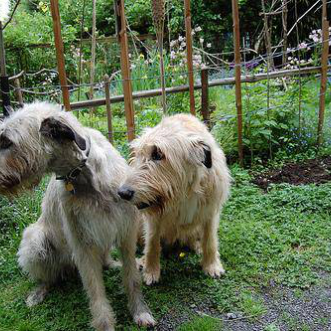

In [9]:
trans.ToPILImage()(img_center_crop)

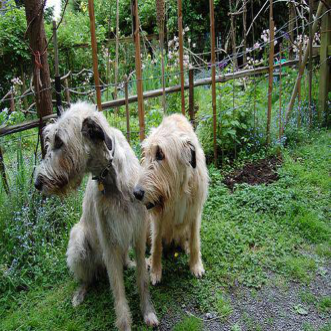

In [10]:
trans.ToPILImage()(img_resize)

In [11]:
def get_extraction_model():
    nasnet = pretrainedmodels.nasnetalarge(num_classes=1000)
    nasnet = nasnet.eval()
    nasnet.avg_pool = nn.AdaptiveAvgPool2d(1)
    del nasnet.dropout
    del nasnet.last_linear
    nasnet.dropout = lambda x:x
    nasnet.last_linear = lambda x:x
    return nasnet

In [12]:
extraction_nasnet = get_extraction_model()

if use_cuda:
    extraction_nasnet.cuda()

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/nasnetalarge-a1897284.pth" to /root/.cache/torch/hub/checkpoints/nasnetalarge-a1897284.pth


In [13]:
def get_bottlenecks(data_loader,extration_model,test_mode=False):
    x_pieces = []
    y_pieces = []
    for x,y in tqdm(iter(data_loader)):
        if use_cuda:
            x = Variable(x)
            y = Variable(y) if not test_mode else y
            x = x.cuda()
            y = y.cuda() if not test_mode else y
        x_pieces.append(extration_model(x).cpu().data.numpy())
        y_pieces.append(y.cpu().data.numpy()) if not test_mode else y_pieces
    bottlenecks_x = np.concatenate(x_pieces)
    bottlenecks_y = np.concatenate(y_pieces) if not test_mode else None
    return bottlenecks_x,bottlenecks_y

In [14]:
bottlenecks_x,bottlenecks_y= get_bottlenecks(train_loader,extraction_nasnet)

100%|██████████| 2556/2556 [2:17:45<00:00,  3.23s/it]


In [15]:
# np.save(bottlenecks_folder/(name+'_x'),bottlenecks_x)
# np.save(bottlenecks_folder/(name+'_y'),bottlenecks_y)

# bottlenecks_x = np.load(bottlenecks_folder/(name + '_x.npy'))
# bottlenecks_y = np.load(bottlenecks_folder/(name + '_y.npy'))

In [16]:
del extraction_nasnet

In [17]:
class TopModule(nn.Module):
    def __init__(self,dropout_ratio):
        super(TopModule, self).__init__()
        self.aff = nn.Linear(4032, 120,bias=use_bias)
        self.dropout_ratio = dropout_ratio
    def forward(self,x):
        x = nn.Dropout(p = dropout_ratio)(x)
        x = self.aff(x)
        return x

In [18]:
criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda()

In [19]:
permutation = np.random.permutation(bottlenecks_x.shape[0])

x_train = bottlenecks_x[permutation][:-int(bottlenecks_x.shape[0]//5)]
x_val = bottlenecks_x[permutation][-int(bottlenecks_x.shape[0]//5):]
y_train = bottlenecks_y[permutation][:-int(bottlenecks_y.shape[0]//5)]
y_val = bottlenecks_y[permutation][-int(bottlenecks_y.shape[0]//5):]

top_only_train_dataset = TensorDataset(torch.FloatTensor(x_train),torch.LongTensor(y_train))

top_only_val_dataset = TensorDataset(torch.FloatTensor(x_val),torch.LongTensor(y_val))

top_only_train_loader = DataLoader(top_only_train_dataset,batch_size=batch_size_top,shuffle=True)
top_only_val_loader = DataLoader(top_only_val_dataset,batch_size=batch_size_top,shuffle=True)

total_dataset = ConcatDataset([top_only_train_dataset,top_only_val_dataset])
total_loader = DataLoader(total_dataset,batch_size=batch_size_top,shuffle=True)

In [20]:
def fit(loader,optimizer,criterion,model=top_only_model,epochs=1500,evaluate=True):
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):  
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
        
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            if use_cuda:
                inputs = inputs.cuda()
                labels = labels.cuda()
        
            optimizer.zero_grad()
        
            # forward + backward 
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()   
        
            optimizer.step()
        
        running_loss += loss.data[0]
    
        print('[%d, %5d] Train_loss: %.3f' \% (epoch+1, i+1, running_loss / len(loader)))
    
        if evaluate:
            model.eval()
            outputs = model(Variable(torch.from_numpy(x_val),volatile=True).cuda() if use_cuda else Variable(torch.from_numpy(x_val),volatile=True))
            labels = torch.from_numpy(y_val).cuda() if use_cuda else torch.from_numpy(y_val)
            labels = Variable(labels,volatile=True)
            loss = criterion(outputs,labels)
            x_val_v = Variable(torch.FloatTensor(x_val),volatile=True).cuda() if use_cuda else Variable(torch.FloatTensor(x_val),volatile=True)
            _,pred = torch.max(model(x_val_v),1)
            val_acc = np.mean(pred.cpu().data.numpy() == labels.cpu().data.numpy())
            val_loss_history.append(loss.cpu().data.numpy())
            val_acc_history.append(val_acc)
    
            print('[%d] Val_loss: %.3f'% (epoch+1, loss))
            print('[%d] Val_acc: %.3f'% (epoch+1, val_acc))
            model.train()
    
    print('Finished Training')
    return val_loss_history,val_acc_history 

SyntaxError: ignored

In [ ]:
val_loss_history,val_acc_history = fit(top_only_train_loader,optimizer,criterion,top_only_model,epochs=1500,evaluate=True)
best_epochs = np.argmin(np.array(val_loss_history))
print(best_epochs)
best_val_loss = min(val_loss_history)
print(best_val_loss)

In [ ]:
top_only_model = TopModule(dropout_ratio)
if use_cuda:
    top_only_model = top_only_model.cuda()
optimizer = optim.Adam(top_only_model.parameters(),lr=learning_rate)
fit(total_loader,optimizer,criterion,top_only_model,epochs=best_epochs,evaluate=False)

In [ ]:
extraction_nasnet = get_extraction_model()

if use_cuda:
    extraction_nasnet.cuda()

bottlenecks_test_x,test_y = get_bottlenecks(test_loader,extraction_nasnet,True)
np.save(bottlenecks_folder/(name+'_test_x'),bottlenecks_test_x)

In [ ]:
torch.save(top_only_model, '/content/drive/My Drive/DogBreeding1.pth')

In [ ]:
del extraction_nasnet

In [ ]:
top_only_model.eval()

In [ ]:
x_test = Variable(torch.FloatTensor(bottlenecks_test_x),volatile=True).cuda() if use_cuda else Variable(torch.FloatTensor(bottlenecks_test_x),volatile=True)
pred_np = (nn.Softmax(1)(top_only_model(x_test))).cpu().data.numpy()
df_pred = pd.DataFrame(pred_np,index=df_test.index,columns=df_test.columns)
df_pred.to_csv(pred_folder/(name+'.csv'))